In [1]:
!pip install -q transformers accelerate datasets==2.18.0 evaluate==0.4.1 seqeval rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.2.0 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from datasets import load_dataset, load_from_disk
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from tqdm import tqdm

In [2]:
qa_pairs_wiki = [
    # 1
    {
        "question": "Apa nama lain dari Undang-Undang Cipta Kerja?",
        "answer": "Undang-Undang Cipta Kerja juga disebut sebagai Omnibus Law."
    },
    # 2
    {
        "question": "Kapan Undang-Undang Cipta Kerja disahkan?",
        "answer": "Undang-Undang Cipta Kerja disahkan pada 5 Oktober 2020."
    },
    # 3
    {
        "question": "Apa tujuan utama dari Undang-Undang Cipta Kerja?",
        "answer": "Tujuannya adalah untuk menciptakan lapangan kerja dan meningkatkan investasi dengan mengurangi persyaratan peraturan."
    },
    # 4
    {
        "question": "Berapa banyak undang-undang yang diamandemen oleh UU Cipta Kerja?",
        "answer": "UU Cipta Kerja mengamandemen 79 undang-undang."
    },
    # 5
    {
        "question": "Apa kritik utama terhadap Undang-Undang Cipta Kerja?",
        "answer": "Kritik utama adalah UU ini dianggap menguntungkan perusahaan besar dan merugikan hak-hak pekerja serta lingkungan."
    },
    # 6
    {
        "question": "Apa status UU Cipta Kerja setelah diputuskan oleh Mahkamah Konstitusi?",
        "answer": "Mahkamah Konstitusi menyatakan UU Cipta Kerja 'inkonstitusional bersyarat' dan harus diperbaiki hingga 25 November 2023."
    },
    # 7
    {
        "question": "Siapa yang mendukung pengesahan Undang-Undang Cipta Kerja?",
        "answer": "Pendukung pengesahan UU Cipta Kerja termasuk PDIP, Golkar, Gerindra, NasDem, PKB, PAN, dan PPP."
    },
    # 8
    {
        "question": "Apa yang terjadi pada pembayaran pesangon dalam UU Cipta Kerja?",
        "answer": "UU Cipta Kerja mengurangi batas pembayaran pesangon dari 32 bulan gaji menjadi 19 bulan gaji."
    },
    # 9
    {
        "question": "Bagaimana aturan tentang upah minimum dalam UU Cipta Kerja?",
        "answer": "Upah minimum ditentukan berdasarkan inflasi dan pertumbuhan ekonomi, serta ada syarat tertentu untuk UMK."
    },
    # 10
    {
        "question": "Apa yang diatur terkait waktu kerja dan cuti dalam UU Cipta Kerja?",
        "answer": "Waktu kerja lembur diatur hingga maksimal 4 jam sehari, dan hari libur berkurang menjadi 1 hari seminggu."
    },
    # 11
    {
        "question": "Bagaimana aturan pekerja asing dalam UU Cipta Kerja?",
        "answer": "UU Cipta Kerja melonggarkan aturan untuk mempermudah perekrutan tenaga kerja asing."
    },
    # 12
    {
        "question": "Apa dampak UU Cipta Kerja terhadap lingkungan?",
        "answer": "Peraturan lingkungan dilonggarkan, terutama untuk proyek berisiko rendah, sementara proyek berisiko tinggi masih harus menyertakan analisis dampak lingkungan."
    },
    # 13
    {
        "question": "Apa peran pemerintah pusat dalam penggunaan lahan berdasarkan UU Cipta Kerja?",
        "answer": "Pemerintah pusat diberi wewenang penuh atas izin penggunaan lahan dalam UU Cipta Kerja."
    },
    # 14
    {
        "question": "Bagaimana dampak UU Cipta Kerja terhadap perpajakan perusahaan?",
        "answer": "Pajak penghasilan badan akan diturunkan secara bertahap menjadi 20% pada 2025."
    },
    # 15
    {
        "question": "Apa yang diatur tentang investasi dalam UU Cipta Kerja?",
        "answer": "UU Cipta Kerja mengurangi daftar sektor yang dilarang untuk investasi swasta dari 300 menjadi hanya 6 sektor."
    },
    # 16
    {
        "question": "Bagaimana dampak UU Cipta Kerja terhadap sektor televisi digital?",
        "answer": "UU Cipta Kerja mengatur tentang penghentian siaran analog paling lambat dua tahun setelah diberlakukan."
    },
    # 17
    {
        "question": "Apa tanggapan serikat buruh internasional terhadap UU Cipta Kerja?",
        "answer": "Serikat Buruh Internasional mengkritik UU ini, menyebutnya merugikan hak-hak buruh."
    },
    # 18
    {
        "question": "Apa tanggapan berbagai gubernur di Indonesia terhadap UU Cipta Kerja?",
        "answer": "Beberapa gubernur, seperti Ridwan Kamil dan Sutarmidji, meminta Presiden untuk mengeluarkan Perppu guna membatalkan UU Cipta Kerja."
    },
    # 19
    {
        "question": "Bagaimana penggunaan influencer dalam mendukung UU Cipta Kerja?",
        "answer": "Beberapa influencer media sosial dibayar untuk mempromosikan UU Cipta Kerja, meski kemudian dikritik keras oleh masyarakat."
    },
    # 20
    {
        "question": "Apa yang memicu unjuk rasa terkait UU Cipta Kerja?",
        "answer": "Unjuk rasa dipicu oleh kekhawatiran bahwa UU ini merugikan hak-hak pekerja diantaranya dengan mengurangi pesangon, memotong cuti wajib, memperbolehkan jam kerja lebih lama, dan memperbolehkan mempekerjakan pekerja kontrak, serta merugikan lingkungan khususnya yang akan menyebabkan penggundulan hutan."
    },
    # 21
    {
        "question": "Kapan dan dimana unjuk rasa terkait UU Cipta Kerja terjadi?",
        "answer": "Sejak Januari 2020, berbagai unjuk rasa digelar di beberapa daerah Indonesia dengan titik orasi berada di depan gedung DPRD dan jalan-jalan lainnya. Puncak demonstrasi di berbagai daerah Indonesia terjadi pada 7-8 Oktober 2020."
    },
    # 22
    {
        "question": "Apa yang terjadi saat unjuk rasa terkait UU Cipta Kerja?",
        "answer": "Beberapa protes berlangsung damai, sementara yang lain berubah menjadi kekerasan, menyebabkan kerusakan properti, serta korban jiwa dan penangkapan. Salah satu peristiwa yang terjadi adalah Halte TransJakarta Bundaran HI dibakar pada tanggal 8 Oktober 2020."
    }
]

In [3]:
qa_pairs = [
    # 1
    {
        "question": "Apa tujuan perubahan dalam Undang-Undang Cipta Kerja terkait ketenagakerjaan?",
        "answer": "Tujuan perubahan adalah untuk penguatan perlindungan kepada tenaga kerja dan meningkatkan peran tenaga kerja dalam mendukung ekosistem investasi."
    },
    # 2
    {
        "question": "Apa yang diatur dalam Pasal 42 tentang tenaga kerja asing?",
        "answer": "Pasal 42 mengatur bahwa pemberi kerja yang mempekerjakan tenaga kerja asing wajib memiliki pengesahan rencana penggunaan tenaga kerja asing dari Pemerintah Pusat."
    },
    # 3
    {
        "question": "Siapa yang dikecualikan dari pengesahan rencana penggunaan tenaga kerja asing menurut Pasal 42?",
        "answer": "Pengecualian diberikan untuk anggota direksi atau dewan komisaris dengan kepemilikan saham, pegawai diplomatik dan konsuler, serta tenaga kerja asing yang dibutuhkan dalam keadaan darurat, vokasi, start-up, dan kunjungan bisnis."
    },
    # 4
    {
        "question": "Apakah pemberi kerja orang perseorangan dapat mempekerjakan tenaga kerja asing?",
        "answer": "Tidak, pemberi kerja orang perseorangan dilarang mempekerjakan tenaga kerja asing."
    },
    # 5
    {
        "question": "Apa yang diwajibkan kepada pemberi kerja yang mempekerjakan tenaga kerja asing menurut Pasal 45?",
        "answer": "Pemberi kerja wajib menunjuk tenaga kerja WNI sebagai pendamping, melaksanakan pendidikan dan pelatihan kerja, serta memulangkan tenaga kerja asing setelah hubungan kerja berakhir."
    },
    # 6
    {
        "question": "Bagaimana ketentuan mengenai perjanjian kerja waktu tertentu dalam Pasal 56?",
        "answer": "Perjanjian kerja untuk waktu tertentu dapat didasarkan pada jangka waktu atau selesainya suatu pekerjaan tertentu, sesuai kesepakatan para pihak."
    },
    # 7
    {
        "question": "Apa saja yang menyebabkan berakhirnya perjanjian kerja menurut Pasal 61?",
        "answer": "Perjanjian kerja berakhir jika pekerja meninggal, berakhirnya jangka waktu, selesainya pekerjaan, adanya putusan pengadilan, atau keadaan tertentu yang disepakati."
    },
    # 8
    {
        "question": "Apakah perjanjian kerja berakhir jika pengusaha meninggal dunia?",
        "answer": "Tidak, perjanjian kerja tidak berakhir dengan meninggalnya pengusaha atau beralihnya hak atas perusahaan."
    },
    # 9
    {
        "question": "Apa kompensasi yang harus diberikan kepada pekerja setelah perjanjian kerja waktu tertentu berakhir?",
        "answer": "Pengusaha wajib memberikan uang kompensasi kepada pekerja yang memiliki masa kerja paling sedikit 1 tahun."
    },
    # 10
    {
        "question": "Bagaimana ketentuan mengenai upah minimum dalam Pasal 88C?",
        "answer": "Upah minimum ditetapkan oleh Gubernur sebagai jaring pengaman, dan merupakan upah minimum provinsi."
    },
    # 11
    {
        "question": "Apa hak pekerja menurut Pasal 88A tentang upah?",
        "answer": "Setiap pekerja berhak atas upah yang timbul saat terjadi hubungan kerja dan berakhir saat putusnya hubungan kerja."
    },
    # 12
    {
        "question": "Bagaimana upah dihitung dalam industri padat karya menurut Pasal 88E?",
        "answer": "Upah minimum pada industri padat karya ditetapkan oleh Gubernur dan dihitung dengan menggunakan formula tertentu."
    },
    # 13
    {
        "question": "Apakah perjanjian kerja waktu tertentu boleh mensyaratkan masa percobaan?",
        "answer": "Tidak, perjanjian kerja untuk waktu tertentu tidak boleh mensyaratkan masa percobaan, dan jika disyaratkan maka batal demi hukum."
    },
    # 14
    {
        "question": "Apakah tenaga kerja asing dapat menduduki jabatan yang mengurusi personalia?",
        "answer": "Tidak, tenaga kerja asing dilarang menduduki jabatan yang mengurusi personalia."
    },
    # 15
    {
        "question": "Apa kewajiban pemberi kerja jika mempekerjakan tenaga kerja asing menurut Pasal 47?",
        "answer": "Pemberi kerja wajib membayar kompensasi atas setiap tenaga kerja asing yang dipekerjakannya."
    },
    # 16
    {
        "question": "Apa yang diatur dalam Pasal 77 terkait waktu kerja?",
        "answer": "Pasal 77 mengatur bahwa waktu kerja maksimal adalah 8 jam per hari dan 40 jam per minggu."
    },
    # 17
    {
        "question": "Bagaimana ketentuan pembayaran upah kerja lembur menurut Pasal 78?",
        "answer": "Pengusaha wajib membayar upah kerja lembur jika mempekerjakan pekerja lebih dari 8 jam per hari atau 40 jam per minggu, dengan batas maksimal 4 jam per hari dan 18 jam per minggu."
    },
    # 18
    {
        "question": "Apa hak pekerja terkait waktu istirahat menurut Pasal 79?",
        "answer": "Pekerja berhak atas istirahat antara jam kerja selama setengah jam setelah bekerja selama 4 jam terus menerus dan istirahat mingguan selama satu hari untuk enam hari kerja."
    },
    # 19
    {
        "question": "Bagaimana upah dihitung jika pekerja dibayar berdasarkan satuan hasil?",
        "answer": "Upah bulanan dihitung sebagai rata-rata penghasilan selama 12 bulan terakhir, dan tidak boleh kurang dari upah minimum."
    },
    # 20
    {
        "question": "Apa sanksi bagi pengusaha yang melanggar ketentuan dalam Pasal 42 ayat (2) tentang pekerja asing?",
        "answer": "Pengusaha dapat dikenai sanksi pidana penjara 1-4 tahun dan/atau denda antara Rp100.000.000 hingga Rp400.000.000."
    }
]

In [4]:
qa_pairs2 = [
    # 1
    {
        "question": "Apa yang diatur dalam Pasal 45 tentang pemulangan tenaga kerja asing?",
        "answer": "Pemberi kerja tenaga kerja asing wajib memulangkan tenaga kerja asing ke negara asalnya setelah hubungan kerja berakhir."
    },
    # 2
    {
        "question": "Apa yang terjadi jika perjanjian kerja dibuat dalam bahasa Indonesia dan bahasa asing?",
        "answer": "Jika terdapat perbedaan penafsiran, maka perjanjian kerja yang berlaku adalah yang dibuat dalam bahasa Indonesia."
    },
    # 3
    {
        "question": "Apa ketentuan mengenai pemberian uang pesangon dalam hal terjadi pemutusan hubungan kerja?",
        "answer": "Pengusaha wajib membayar uang pesangon yang besarnya ditentukan berdasarkan masa kerja pekerja, dimulai dari 1 bulan upah untuk masa kerja kurang dari 1 tahun hingga 9 bulan upah untuk masa kerja 8 tahun atau lebih."
    },
    # 4
    {
        "question": "Bagaimana ketentuan pengakhiran hubungan kerja menurut Pasal 61A?",
        "answer": "Jika perjanjian kerja waktu tertentu berakhir, pengusaha wajib memberikan uang kompensasi kepada pekerja yang memiliki masa kerja paling sedikit 1 tahun."
    },
    # 5
    {
        "question": "Apa sanksi yang diberikan kepada pengusaha yang tidak membayar upah lembur?",
        "answer": "Pengusaha yang tidak membayar upah lembur dapat dikenai sanksi pidana atau denda sesuai ketentuan peraturan perundang-undangan."
    },
    # 6
    {
        "question": "Apa yang terjadi jika pekerja meninggal dunia menurut Pasal 61?",
        "answer": "Jika pekerja meninggal dunia, ahli warisnya berhak mendapatkan hak-hak pekerja sesuai dengan peraturan perundang-undangan atau perjanjian kerja."
    },
    # 7
    {
        "question": "Apa yang diatur dalam Pasal 47 terkait kompensasi tenaga kerja asing?",
        "answer": "Pemberi kerja wajib membayar kompensasi untuk setiap tenaga kerja asing yang dipekerjakan, kecuali instansi pemerintah, perwakilan negara asing, dan lembaga sosial."
    },
    # 8
    {
        "question": "Bagaimana ketentuan mengenai perjanjian kerja dalam Pasal 57?",
        "answer": "Perjanjian kerja untuk waktu tertentu harus dibuat secara tertulis dalam bahasa Indonesia dan huruf latin."
    },
    # 9
    {
        "question": "Apa hak pekerja/buruh terkait dengan cuti tahunan menurut Pasal 79?",
        "answer": "Pekerja/buruh berhak mendapatkan cuti tahunan paling sedikit 12 hari kerja setelah bekerja selama 12 bulan secara terus menerus."
    },
    # 10
    {
        "question": "Bagaimana penghitungan upah dalam Pasal 88D?",
        "answer": "Upah minimum dihitung dengan formula UMt+1 = UMt + (UMt x %PEt), di mana UMt adalah upah minimum yang ditetapkan pada periode sebelumnya."
    },
    # 11
    {
        "question": "Apa yang diatur dalam Pasal 77A terkait waktu kerja melebihi ketentuan?",
        "answer": "Pengusaha dapat memberlakukan waktu kerja yang melebihi 8 jam sehari untuk jenis pekerjaan atau sektor usaha tertentu, sesuai skema periode kerja yang diatur dalam Peraturan Pemerintah."
    },
    # 12
    {
        "question": "Apa hak pekerja jika hubungan kerja diputuskan sebelum waktu perjanjian berakhir?",
        "answer": "Pihak yang memutuskan hubungan kerja sebelum waktunya harus membayar ganti rugi kepada pihak lainnya sebesar upah sampai batas waktu berakhirnya perjanjian."
    },
    # 13
    {
        "question": "Bagaimana ketentuan tentang perjanjian kerja waktu tertentu yang diatur dalam Pasal 56?",
        "answer": "Perjanjian kerja waktu tertentu bisa didasarkan pada jangka waktu atau selesainya suatu pekerjaan, dan disepakati oleh kedua belah pihak."
    },
    # 14
    {
        "question": "Apa yang diatur dalam Pasal 88F terkait upah minimum?",
        "answer": "Upah minimum berlaku bagi pekerja dengan masa kerja kurang dari satu tahun, dan pengusaha dilarang membayar upah lebih rendah dari upah minimum."
    },
    # 15
    {
        "question": "Apa yang diatur dalam Pasal 88B tentang penetapan upah?",
        "answer": "Upah ditetapkan berdasarkan satuan waktu dan/atau satuan hasil."
    },
    # 16
    {
        "question": "Apa saja manfaat jaminan kehilangan pekerjaan menurut Pasal 46D?",
        "answer": "Manfaat jaminan kehilangan pekerjaan meliputi pelatihan dan sertifikasi, uang tunai, serta fasilitasi penempatan kerja."
    },
    # 17
    {
        "question": "Apa yang diatur dalam Pasal 92A terkait peninjauan upah?",
        "answer": "Pengusaha wajib melakukan peninjauan upah secara berkala dengan memperhatikan kemampuan perusahaan dan produktivitas pekerja."
    },
    # 18
    {
        "question": "Apa yang diatur dalam Pasal 153 terkait larangan pemutusan hubungan kerja?",
        "answer": "Pengusaha dilarang memutus hubungan kerja dengan alasan pekerja sakit, menjalankan ibadah, hamil, atau mendirikan serikat pekerja, antara lain."
    },
    # 19
    {
        "question": "Apa ketentuan terkait penghargaan masa kerja dalam Pasal 156?",
        "answer": "Pengusaha wajib memberikan uang penghargaan masa kerja berdasarkan masa kerja pekerja, dimulai dari 2 bulan upah untuk masa kerja 3 tahun hingga 8 bulan upah untuk masa kerja lebih dari 21 tahun."
    },
    # 20
    {
        "question": "Apa ketentuan mengenai kompensasi bagi pekerja yang terkena PHK dalam Pasal 154A?",
        "answer": "Pemutusan hubungan kerja dapat terjadi karena alasan efisiensi, penutupan perusahaan, atau pekerja mengundurkan diri, di mana pekerja berhak mendapatkan kompensasi sesuai ketentuan."
    }
]

In [5]:
quests = []
answers = []
data = []

def create_instruction(instruction, answer):
    prompt = f"### Human: {instruction} ### Assistant: {answer}"
    return prompt

for d in qa_pairs_wiki:
    prompt = create_instruction(d['question'], d['answer'])
    data.append(prompt)
    quests.append(d['question'])
    answers.append(d['answer'])

for d in qa_pairs:
    prompt = create_instruction(d['question'], d['answer'])
    data.append(prompt)
    quests.append(d['question'])
    answers.append(d['answer'])

for d in qa_pairs2:
    prompt = create_instruction(d['question'], d['answer'])
    data.append(prompt)
    quests.append(d['question'])
    answers.append(d['answer'])

In [6]:
d = {"question": quests, "answer": answers, "text": data}

In [7]:
eval_dataset = Dataset.from_dict(d)
eval_dataset

Dataset({
    features: ['question', 'answer', 'text'],
    num_rows: 62
})

In [8]:
eval_dataset['text'][0]

'### Human: Apa nama lain dari Undang-Undang Cipta Kerja? ### Assistant: Undang-Undang Cipta Kerja juga disebut sebagai Omnibus Law.'

In [9]:
df = eval_dataset.to_pandas()
df

,question,answer,text
0,Apa nama lain dari Undang-Undang Cipta Kerja?,Undang-Undang Cipta Kerja juga disebut sebagai...,### Human: Apa nama lain dari Undang-Undang Ci...
1,Kapan Undang-Undang Cipta Kerja disahkan?,Undang-Undang Cipta Kerja disahkan pada 5 Okto...,### Human: Kapan Undang-Undang Cipta Kerja dis...
2,Apa tujuan utama dari Undang-Undang Cipta Kerja?,Tujuannya adalah untuk menciptakan lapangan ke...,### Human: Apa tujuan utama dari Undang-Undang...
3,Berapa banyak undang-undang yang diamandemen o...,UU Cipta Kerja mengamandemen 79 undang-undang.,### Human: Berapa banyak undang-undang yang di...
4,Apa kritik utama terhadap Undang-Undang Cipta ...,Kritik utama adalah UU ini dianggap menguntung...,### Human: Apa kritik utama terhadap Undang-Un...
...,...,...,...
57,Apa saja manfaat jaminan kehilangan pekerjaan ...,Manfaat jaminan kehilangan pekerjaan meliputi ...,### Human: Apa saja manfaat jaminan kehilangan...
58,Apa yang diatur dalam Pasal 92A terkait peninj...,Pengusaha wajib melakukan peninjauan upah seca...,### Human: Apa yang diatur dalam Pasal 92A ter...
59,Apa yang diatur dalam Pasal 153 terkait larang...,Pengusaha dilarang memutus hubungan kerja deng...,### Human: Apa yang diatur dalam Pasal 153 ter...
60,Apa ketentuan terkait penghargaan masa kerja d...,Pengusaha wajib memberikan uang penghargaan ma...,### Human: Apa ketentuan terkait penghargaan m...


In [11]:
n_gpus = torch.cuda.device_count()
max_memory = {i: f"{15000}MB" for i in range(n_gpus)}
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "Willy030125/CiptakerLM-v1"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map=device,
                                             max_memory=max_memory,
                                             torch_dtype=torch.bfloat16,
                                             use_cache=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [11]:
def create_instruction(instruction):
    prompt = f"### Human: {instruction} ### Assistant: "
    return prompt

def generate(
    instruction,
    max_new_tokens=2048,
    temperature=0.1,
    top_p=0.95,
    top_k=40,
    num_beams=4,
    **kwargs
):

    prompt = create_instruction(instruction)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        do_sample=True,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=generation_config,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
            early_stopping=True
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s, skip_special_tokens=True)
    return output.split("### Assistant:")[1].strip()

### Model Evaluation: Perplexity

In [12]:
perplexity = []

model.eval()

for row in tqdm(eval_dataset['text']):
    inputs = tokenizer(row, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
      loss = outputs.loss  # Cross-entropy loss
    # Calculate perplexity
    perplexity.append(torch.exp(loss).item())

100%|██████████| 62/62 [00:49<00:00,  1.25it/s]


In [13]:
perplexity = torch.tensor(perplexity)
all_perplexity = torch.mean(perplexity)
print(f"Perplexity across all dataset: {all_perplexity}")

Perplexity across all dataset: 1.0561115741729736


How to measure the Perplexity?<br>
Perplexity is the exponential (e^x) of Losses, for example the loss is 0.05:

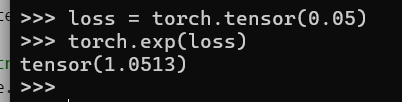

### Model Evaluation: ROUGE and BLEU

In [19]:
import evaluate

# Load ROUGE metric
rouge = evaluate.load('rouge')

# Load BLEU metric
bleu = evaluate.load('bleu')

In [16]:
eval_rouge = []
eval_bleu = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    predicted = generate(row['question'])
    eval_rouge.append(rouge.compute(predictions=[predicted], references=[row['answer']]))
    eval_bleu.append(bleu.compute(predictions=[predicted], references=[row['answer']]))

100%|██████████| 62/62 [47:07<00:00, 45.61s/it]


In [17]:
rouge_scores = [i['rougeL'] for i in eval_rouge]
bleu_scores = [i['bleu'] for i in eval_bleu]

rouge_scores = torch.tensor(rouge_scores)
bleu_scores = torch.tensor(bleu_scores)

all_rouge_scores = torch.mean(rouge_scores)
all_bleu_scores = torch.mean(bleu_scores)

print(f"ROUGE-L all scores: {all_rouge_scores}")
print(f"BLEU all scores: {all_bleu_scores}")

ROUGE-L all scores: 0.7134693037488239
BLEU all scores: 0.6164010763168335
